<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance

**Analyze Big Financial Data**

O'Reilly (2014)

Yves Hilpisch

<img style="border:0px solid grey;" src="http://hilpisch.com/python_for_finance.png" alt="Python for Finance" width="30%" align="left" border="0">

**Buy the book ** |
<a href='http://shop.oreilly.com/product/0636920032441.do' target='_blank'>O'Reilly</a> |
<a href='http://www.amazon.com/Yves-Hilpisch/e/B00JCYHHJM' target='_blank'>Amazon</a>

**All book codes & IPYNBs** |
<a href="http://oreilly.quant-platform.com">http://oreilly.quant-platform.com</a>

**The Python Quants GmbH** | <a href='http://tpq.io' target='_blank'>http://tpq.io</a>

**Contact us** | <a href='mailto:pff@tpq.io'>pff@tpq.io</a>

# Volatility Options

In [1]:
from pylab import plt
plt.style.use('ggplot')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import warnings; warnings.simplefilter('ignore')

## The VSTOXX Data

In [2]:
import sys
sys.path.append('../python3/')
sys.path.append('../python3/dxa')

In [3]:
import numpy as np
import pandas as pd

### VSTOXX Index Data

In [4]:
url = 'http://www.stoxx.com/download/historical_values/h_vstoxx.txt'
vstoxx_index = pd.read_csv(url, index_col=0, header=2,
                           parse_dates=True, dayfirst=True,
                           sep=',')

In [5]:
vstoxx_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4357 entries, 1999-01-04 to 2016-02-12
Data columns (total 9 columns):
V2TX    4357 non-null float64
V6I1    3906 non-null float64
V6I2    4357 non-null float64
V6I3    4296 non-null float64
V6I4    4357 non-null float64
V6I5    4357 non-null float64
V6I6    4340 non-null float64
V6I7    4357 non-null float64
V6I8    4343 non-null float64
dtypes: float64(9)
memory usage: 340.4 KB


In [6]:
vstoxx_index = vstoxx_index[('2013/12/31' < vstoxx_index.index)
                            & (vstoxx_index.index < '2014/4/1')]

In [7]:
np.round(vstoxx_index.tail(), 2)

,V2TX,V6I1,V6I2,V6I3,V6I4,V6I5,V6I6,V6I7,V6I8
Date,,,,,,,,,
2014-03-25,18.26,18.23,18.31,19.04,19.84,20.31,18.11,20.83,21.20
2014-03-26,17.59,17.48,17.70,18.45,19.42,20.00,20.26,20.45,20.86
2014-03-27,17.64,17.50,17.76,18.62,19.49,20.05,20.11,20.49,20.94
2014-03-28,17.03,16.68,17.29,18.33,19.30,19.83,20.14,20.38,20.82
2014-03-31,17.66,17.61,17.69,18.57,19.43,20.04,19.98,20.44,20.90


### VSTOXX Futures Data

In [8]:
vstoxx_futures = pd.read_excel('./source/vstoxx_march_2014.xlsx',
                               'vstoxx_futures')

In [9]:
vstoxx_futures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 8 columns):
A_DATE                       504 non-null datetime64[ns]
A_EXP_YEAR                   504 non-null int64
A_EXP_MONTH                  504 non-null int64
A_CALL_PUT_FLAG              504 non-null object
A_EXERCISE_PRICE             504 non-null int64
A_SETTLEMENT_PRICE_SCALED    504 non-null int64
A_PRODUCT_ID                 504 non-null object
SETTLE                       504 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 31.6+ KB


In [10]:
del vstoxx_futures['A_SETTLEMENT_PRICE_SCALED']
del vstoxx_futures['A_CALL_PUT_FLAG']
del vstoxx_futures['A_EXERCISE_PRICE']
del vstoxx_futures['A_PRODUCT_ID']

In [11]:
columns = ['DATE', 'EXP_YEAR', 'EXP_MONTH', 'PRICE']
vstoxx_futures.columns = columns

In [12]:
import datetime as dt
import calendar

def third_friday(date):
    day = 21 - (calendar.weekday(date.year, date.month, 1) + 2) % 7
    return dt.datetime(date.year, date.month, day)

In [13]:
set(vstoxx_futures['EXP_MONTH'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [14]:
third_fridays = {}
for month in set(vstoxx_futures['EXP_MONTH']):
    third_fridays[month] = third_friday(dt.datetime(2014, month, 1))

In [15]:
third_fridays

{1: datetime.datetime(2014, 1, 17, 0, 0),
 2: datetime.datetime(2014, 2, 21, 0, 0),
 3: datetime.datetime(2014, 3, 21, 0, 0),
 4: datetime.datetime(2014, 4, 18, 0, 0),
 5: datetime.datetime(2014, 5, 16, 0, 0),
 6: datetime.datetime(2014, 6, 20, 0, 0),
 7: datetime.datetime(2014, 7, 18, 0, 0),
 8: datetime.datetime(2014, 8, 15, 0, 0),
 9: datetime.datetime(2014, 9, 19, 0, 0),
 10: datetime.datetime(2014, 10, 17, 0, 0),
 11: datetime.datetime(2014, 11, 21, 0, 0)}

In [16]:
tf = lambda x: third_fridays[x]
vstoxx_futures['MATURITY'] = vstoxx_futures['EXP_MONTH'].apply(tf)

In [17]:
vstoxx_futures.tail()

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY
499,2014-03-31,2014,7,20.40,2014-07-18
500,2014-03-31,2014,8,20.70,2014-08-15
501,2014-03-31,2014,9,20.95,2014-09-19
502,2014-03-31,2014,10,21.05,2014-10-17
503,2014-03-31,2014,11,21.25,2014-11-21


### VSTOXX Options Data

In [18]:
vstoxx_options = pd.read_excel('./source/vstoxx_march_2014.xlsx',
                               'vstoxx_options')

In [19]:
vstoxx_options.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46960 entries, 0 to 46959
Data columns (total 8 columns):
A_DATE                       46960 non-null datetime64[ns]
A_EXP_YEAR                   46960 non-null int64
A_EXP_MONTH                  46960 non-null int64
A_CALL_PUT_FLAG              46960 non-null object
A_EXERCISE_PRICE             46960 non-null int64
A_SETTLEMENT_PRICE_SCALED    46960 non-null int64
A_PRODUCT_ID                 46960 non-null object
SETTLE                       46960 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 2.9+ MB


In [20]:
del vstoxx_options['A_SETTLEMENT_PRICE_SCALED']
del vstoxx_options['A_PRODUCT_ID']

In [21]:
columns = ['DATE', 'EXP_YEAR', 'EXP_MONTH', 'TYPE', 'STRIKE', 'PRICE']
vstoxx_options.columns = columns

In [22]:
vstoxx_options['MATURITY'] = vstoxx_options['EXP_MONTH'].apply(tf)

In [23]:
vstoxx_options.head()

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY
0,2014-01-02,2014,1,C,1000,7.95,2014-01-17
1,2014-01-02,2014,1,C,1500,3.05,2014-01-17
2,2014-01-02,2014,1,C,1600,2.20,2014-01-17
3,2014-01-02,2014,1,C,1700,1.60,2014-01-17
4,2014-01-02,2014,1,C,1800,1.15,2014-01-17


In [24]:
vstoxx_options['STRIKE'] = vstoxx_options['STRIKE'] / 100.

In [25]:
save = False
if save is True:
    import warnings
    warnings.simplefilter('ignore')
    h5 = pd.HDFStore('./source/vstoxx_march_2014.h5',
                     complevel=9, complib='blosc')
    h5['vstoxx_index'] = vstoxx_index
    h5['vstoxx_futures'] = vstoxx_futures
    h5['vstoxx_options'] = vstoxx_options
    h5.close()

## Model Calibration

### Relevant Market Data

In [26]:
pricing_date = dt.datetime(2014, 3, 31)
  # last trading day in March 2014
maturity = third_fridays[10]
  # October maturity
initial_value = vstoxx_index['V2TX'][pricing_date]
  # VSTOXX on pricing_date
forward = vstoxx_futures[(vstoxx_futures.DATE == pricing_date)
            & (vstoxx_futures.MATURITY == maturity)]['PRICE'].values[0]

In [27]:
tol = 0.20
option_selection = \
    vstoxx_options[(vstoxx_options.DATE == pricing_date)
                 & (vstoxx_options.MATURITY == maturity)
                 & (vstoxx_options.TYPE == 'C')
                 & (vstoxx_options.STRIKE > (1 - tol) * forward)
                 & (vstoxx_options.STRIKE < (1 + tol) * forward)]                            

In [28]:
option_selection

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY
46482,2014-03-31,2014,10,C,17.0,4.85,2014-10-17
46483,2014-03-31,2014,10,C,18.0,4.30,2014-10-17
46484,2014-03-31,2014,10,C,19.0,3.80,2014-10-17
46485,2014-03-31,2014,10,C,20.0,3.40,2014-10-17
46486,2014-03-31,2014,10,C,21.0,3.05,2014-10-17
46487,2014-03-31,2014,10,C,22.0,2.75,2014-10-17
46488,2014-03-31,2014,10,C,23.0,2.50,2014-10-17
46489,2014-03-31,2014,10,C,24.0,2.25,2014-10-17
46490,2014-03-31,2014,10,C,25.0,2.10,2014-10-17


### Option Modeling

In [29]:
from dxa import *

In [30]:
me_vstoxx = market_environment('me_vstoxx', pricing_date)

In [31]:
me_vstoxx.add_constant('initial_value', initial_value)
me_vstoxx.add_constant('final_date', maturity)
me_vstoxx.add_constant('currency', 'EUR')

In [32]:
me_vstoxx.add_constant('frequency', 'B')
me_vstoxx.add_constant('paths', 10000)

In [33]:
csr = constant_short_rate('csr', 0.01)
  # somewhat arbitrarily chosen here

In [34]:
me_vstoxx.add_curve('discount_curve', csr)

In [35]:
# parameters to be calibrated later
me_vstoxx.add_constant('kappa', 1.0)
me_vstoxx.add_constant('theta', 1.2 * initial_value)
vol_est =  vstoxx_index['V2TX'].std() \
            * np.sqrt(len(vstoxx_index['V2TX']) / 252.)
me_vstoxx.add_constant('volatility', vol_est)

In [36]:
vol_est

1.0384283035169346

In [37]:
vstoxx_model = square_root_diffusion('vstoxx_model', me_vstoxx)

In [38]:
me_vstoxx.add_constant('strike', forward)
me_vstoxx.add_constant('maturity', maturity)

In [39]:
payoff_func = 'np.maximum(maturity_value - strike, 0)'

In [40]:
vstoxx_eur_call = valuation_mcs_european('vstoxx_eur_call',
                        vstoxx_model, me_vstoxx, payoff_func)

In [41]:
vstoxx_eur_call.present_value()

0.35165600000000002

In [42]:
option_models = {}
for option in option_selection.index:
    strike = option_selection['STRIKE'].ix[option]
    me_vstoxx.add_constant('strike', strike)
    option_models[option] = \
                        valuation_mcs_european(
                                'eur_call_%d' % strike,
                                vstoxx_model,
                                me_vstoxx,
                                payoff_func)

In [43]:
def calculate_model_values(p0):
    ''' Returns all relevant option values.
    
    Parameters
    ===========
    p0 : tuple/list
        tuple of kappa, theta, volatility
    
    Returns
    =======
    model_values : dict
        dictionary with model values
    '''
    kappa, theta, volatility = p0
    vstoxx_model.update(kappa=kappa,
                        theta=theta,
                        volatility=volatility)
    model_values = {}
    for option in option_models:
       model_values[option] = \
         option_models[option].present_value(fixed_seed=True)
    return model_values

In [44]:
calculate_model_values((0.5, 27.5, vol_est))

{46482: 3.2064010000000001,
 46483: 2.4123540000000001,
 46484: 1.731028,
 46485: 1.178823,
 46486: 0.76042100000000001,
 46487: 0.46249000000000001,
 46488: 0.26366200000000001,
 46489: 0.142177,
 46490: 0.072190000000000004}

### Calibration Procedure

In [45]:
i = 0
def mean_squared_error(p0):
    ''' Returns the mean-squared error given
    the model and market values.
    
    Parameters
    ===========
    p0 : tuple/list
        tuple of kappa, theta, volatility
    
    Returns
    =======
    MSE : float
        mean-squared error
    '''
    global i
    model_values = np.array(list(calculate_model_values(p0).values()))
    market_values = option_selection['PRICE'].values
    option_diffs = model_values - market_values
    MSE = np.sum(option_diffs ** 2) / len(option_diffs)
      # vectorized MSE calculation
    if i % 20 == 0:
        if i == 0:
            print('%4s  %6s  %6s  %6s --> %6s' % 
                 ('i', 'kappa', 'theta', 'vola', 'MSE'))
        print('%4d  %6.3f  %6.3f  %6.3f --> %6.3f' % 
                (i, p0[0], p0[1], p0[2], MSE))
    i += 1
    return MSE        

In [46]:
mean_squared_error((0.5, 27.5, vol_est))

   i   kappa   theta    vola -->    MSE
   0   0.500  27.500   1.038 -->  4.390


4.3899900376937779

In [47]:
import scipy.optimize as spo

In [48]:
%%time
i = 0
opt_global = spo.brute(mean_squared_error,
                ((0.5, 3.01, 0.5),  # range for kappa
                 (15., 30.1, 5.),  # range for theta
                 (0.5, 5.51, 1)),  # range for volatility
                 finish=None)

   i   kappa   theta    vola -->    MSE
   0   0.500  15.000   0.500 --> 10.393
  20   0.500  30.000   1.500 -->  2.071
  40   1.000  25.000   3.500 -->  0.180
  60   1.500  20.000   5.500 -->  0.718
  80   2.000  20.000   1.500 -->  5.501
 100   2.500  15.000   3.500 -->  5.571
 120   2.500  30.000   5.500 --> 22.992
 140   3.000  30.000   1.500 --> 14.493
CPU times: user 11.1 s, sys: 1.75 s, total: 12.8 s
Wall time: 12.8 s


In [49]:
i = 0
mean_squared_error(opt_global)

   i   kappa   theta    vola -->    MSE
   0   1.500  20.000   4.500 -->  0.008


0.0076468730485555626

In [50]:
%%time
i = 0
opt_local = spo.fmin(mean_squared_error, opt_global,
                     xtol=0.00001, ftol=0.00001,
                     maxiter=100, maxfun=350)

   i   kappa   theta    vola -->    MSE
   0   1.500  20.000   4.500 -->  0.008
  20   1.510  19.235   4.776 -->  0.008
  40   1.563  18.926   4.844 -->  0.005
  60   1.555  18.957   4.828 -->  0.005
  80   1.556  18.947   4.832 -->  0.005
 100   1.556  18.948   4.831 -->  0.005
 120   1.556  18.948   4.831 -->  0.005
Optimization terminated successfully.
         Current function value: 0.004654
         Iterations: 64
         Function evaluations: 138
CPU times: user 10.6 s, sys: 1.59 s, total: 12.2 s
Wall time: 12.2 s


In [51]:
i = 0
mean_squared_error(opt_local)

   i   kappa   theta    vola -->    MSE
   0   1.556  18.948   4.831 -->  0.005


0.0046542736439999875

In [52]:
calculate_model_values(opt_local)

{46482: 4.7465970000000004,
 46483: 4.2869229999999998,
 46484: 3.8633459999999999,
 46485: 3.4741439999999999,
 46486: 3.119211,
 46487: 2.7939059999999998,
 46488: 2.494882,
 46489: 2.2247750000000002,
 46490: 1.9811099999999999}

In [53]:
pd.options.mode.chained_assignment = None
option_selection['MODEL'] = \
        np.array(list(calculate_model_values(opt_local).values()))
option_selection['ERRORS'] = \
        option_selection['MODEL'] - option_selection['PRICE']

In [54]:
option_selection[['MODEL', 'PRICE', 'ERRORS']]

,MODEL,PRICE,ERRORS
46482,4.746597,4.85,-0.103403
46483,4.286923,4.30,-0.013077
46484,3.863346,3.80,0.063346
46485,3.474144,3.40,0.074144
46486,3.119211,3.05,0.069211
46487,2.793906,2.75,0.043906
46488,2.494882,2.50,-0.005118
46489,2.224775,2.25,-0.025225
46490,1.981110,2.10,-0.118890


In [55]:
round(option_selection['ERRORS'].mean(), 3)

-0.002

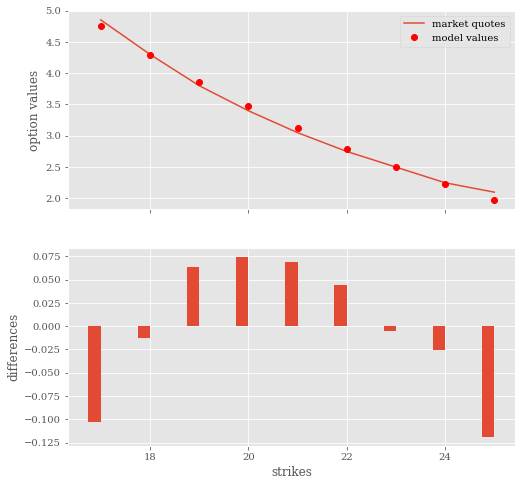

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
fix, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8, 8))
strikes = option_selection['STRIKE'].values
ax1.plot(strikes, option_selection['PRICE'], label='market quotes')
ax1.plot(strikes, option_selection['MODEL'], 'ro', label='model values')
ax1.set_ylabel('option values')
ax1.grid(True)
ax1.legend(loc=0)
wi = 0.25
ax2.bar(strikes - wi / 2., option_selection['ERRORS'],
        label='market quotes', width=wi)
ax2.grid(True)
ax2.set_ylabel('differences')
ax2.set_xlabel('strikes')
# tag: vstoxx_calibration
# title: Calibrated model values for VSTOXX call options vs. market quotes

## American Options on the VSTOXX

### Modeling Option Positions

In [57]:
me_vstoxx = market_environment('me_vstoxx', pricing_date)
me_vstoxx.add_constant('initial_value', initial_value)
me_vstoxx.add_constant('final_date', pricing_date)
me_vstoxx.add_constant('currency', 'NONE')

In [58]:
# adding optimal parameters to environment
me_vstoxx.add_constant('kappa', opt_local[0])
me_vstoxx.add_constant('theta', opt_local[1])
me_vstoxx.add_constant('volatility', opt_local[2])

In [59]:
me_vstoxx.add_constant('model', 'srd')

In [60]:
payoff_func = 'np.maximum(strike - instrument_values, 0)'

In [61]:
shared = market_environment('share', pricing_date)
shared.add_constant('maturity', maturity)
shared.add_constant('currency', 'EUR')

In [62]:
option_positions = {}
  # dictionary for option positions
option_environments = {}
  # dictionary for option environments
for option in option_selection.index:
    option_environments[option] = \
        market_environment('am_put_%d' % option, pricing_date)
        # define new option environment, one for each option
    strike = option_selection['STRIKE'].ix[option]
      # pick the relevant strike
    option_environments[option].add_constant('strike', strike)
      # add it to the environment
    option_environments[option].add_environment(shared)
      # add the shared data
    option_positions['am_put_%d' % strike] = \
                    derivatives_position(
                        'am_put_%d' % strike,
                        quantity=100.,
                        underlying='vstoxx_model',
                        mar_env=option_environments[option],
                        otype='American',
                        payoff_func=payoff_func)

### The Options Portfolio

In [63]:
val_env = market_environment('val_env', pricing_date)
val_env.add_constant('starting_date', pricing_date)
val_env.add_constant('final_date', pricing_date)
  # temporary value, is updated during valuation
val_env.add_curve('discount_curve', csr)
val_env.add_constant('frequency', 'B')
val_env.add_constant('paths', 25000)

In [64]:
underlyings = {'vstoxx_model' : me_vstoxx}

In [65]:
portfolio = derivatives_portfolio('portfolio', option_positions,
                                  val_env, underlyings)

In [66]:
%time results = portfolio.get_statistics(fixed_seed=True)

CPU times: user 31.7 s, sys: 2.73 s, total: 34.5 s
Wall time: 33.6 s


In [67]:
results.sort_values(by='name')

,name,quant.,value,curr.,pos_value,pos_delta,pos_vega
0,am_put_17,100.0,4.575197,EUR,457.5197,-24.85,102.77
1,am_put_18,100.0,5.203648,EUR,520.3648,-30.62,107.93
2,am_put_19,100.0,5.872686,EUR,587.2686,-33.31,107.79
3,am_put_20,100.0,6.578714,EUR,657.8714,-34.82,110.01
4,am_put_21,100.0,7.320523,EUR,732.0523,-39.46,105.20
5,am_put_22,100.0,8.081625,EUR,808.1625,-40.61,102.38
6,am_put_23,100.0,8.871962,EUR,887.1962,-43.26,104.37
7,am_put_24,100.0,9.664272,EUR,966.4272,-40.14,101.04
8,am_put_25,100.0,10.475168,EUR,1047.5168,-45.74,102.81


In [68]:
results[['pos_value','pos_delta','pos_vega']].sum()

pos_value    6664.3795
pos_delta    -332.8100
pos_vega      944.3000
dtype: float64

## Conclusions

## Further Reading

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://www.pythonquants.com" target="_blank">www.pythonquants.com</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a>

<a href="mailto:analytics@pythonquants.com">analytics@pythonquants.com</a>

**Python Quant Platform** |
<a href="http://oreilly.quant-platform.com">http://oreilly.quant-platform.com</a>

**Derivatives Analytics with Python** |
<a href="http://www.derivatives-analytics-with-python.com" target="_blank">Derivatives Analytics @ Wiley Finance</a>

**Python for Finance** |
<a href="http://shop.oreilly.com/product/0636920032441.do" target="_blank">Python for Finance @ O'Reilly</a>